# SQUANCH demonstration: superdense coding

In [1]:
import numpy as np
import time 
import matplotlib.image as image
import matplotlib.pyplot as plt
from squanch import *

This Jupyter notebook contains the source code for the [superdense coding demonstration](https://att-innovate.github.io/squanch/demos/superdense-coding.html). Refer to the documentation for more detailed explanations. 

Superdense coding is a process whereby two parties sharing an entangled pair can send two classical bits with a single qubit. Conecptually, it is the inverse of quantum teleportation. We'll be implementing the following circuit diagram of superdense information transmission. Charlie will distribute Bell pairs to Alice, who will send a bitstream of an image, and Bob, who will receive and reconstruct Alice's information. Any dropped qubits lost to attenuation will have their bits replaced with 0.

![Superdense coding circuit](../docs/source/img/superdenseABC-small.png)

We'll be using the above circuit diagram to describe a three-party quantum superdense coding protocol. There are three agents: Charlie distributes entangled particles to Alice and Bob, Alice encodes her information in her particles and sends them to Bob, who decodes the information by matching Alice's qubits with his own qubits received from Charlie.

1. Charlie generates EPR pairs in the state $\frac{1}{\sqrt{2}} \left (\lvert 00 \rangle + \lvert 11 \rangle \right )$. He sends one particle to Alice and the other to Bob.

2. Alice encodes her two bits of classical inforation in the relative sign and phase of her qubit by acting with the Pauli-X and -Z gates. Formally, if she has two bits, $b_1$ and $b_2$, she applies X if $b_2 = 1$ and then applies Z if $b_1 = 1$. She then sends the modified qubit to Bob.

3. Bob disentangles the X and Z components of the qubit by applying CNOT and H to Alice's qubit and Charlie's qubit. He then measures each of Alice's and Charlie's qubits to obtain $b_1$ and $b_2$, respectively.

We'll also use SQUANCH's built-in timing functionality to track the simulated time for each agent to complete their part of the protocol assuming a photon pulse interval of 1ns.

In [2]:
class Charlie(Agent):
    '''Charlie distributes Bell pairs between Alice and Bob.'''
    def run(self):
        for qsys in self.stream:
            a, b = qsys.qubits
            H(a)
            CNOT(a, b)
            self.qsend(alice, a)
            self.qsend(bob, b)
        self.output({"t": self.time})

In [3]:
class Alice(Agent):
    '''Alice sends information to Bob via superdense coding'''
    def run(self):
        for _ in self.stream:
            bit1 = self.data.pop(0)
            bit2 = self.data.pop(0)
            q = self.qrecv(charlie)
            if q is not None: # qubit could be lost due to attenuation errors
                if bit2 == 1: X(q)
                if bit1 == 1: Z(q)
            self.qsend(bob, q)
        self.output({"t": self.time})

In [4]:
class Bob(Agent):
    '''Bob receives Alice's transmissions and reconstructs her information'''
    def run(self):
        bits = []
        for _ in self.stream:
            a = self.qrecv(alice)
            c = self.qrecv(charlie)
            if a is not None and c is not None:
                CNOT(a, c)
                H(a)
                bits.extend([a.measure(), c.measure()])
            else:
                bits.extend([0,0])
        self.output({"t": self.time, "bits": bits})

## Running the simulation

In [5]:
# Load an image and serialize it to a bitstream
img = image.imread("../docs/source/img/foundryLogo.bmp")
bitstream = list(np.unpackbits(img))

# Allocate a shared Hilbert space and output object to pass to agents
mem = Agent.shared_hilbert_space(2, int(len(bitstream) / 2))
out = Agent.shared_output()

# Make agent instances
alice = Alice(mem, out, data = bitstream)
bob = Bob(mem, out)
charlie = Charlie(mem, out)

# Set photon transmission rate
alice.pulse_length = 1e-9
bob.pulse_length = 1e-9
charlie.pulse_length = 1e-9

# Connect the agents with simulated fiber optic lines; see squanch.channels module
alice.qconnect(bob, FiberOpticQChannel, length=1.0)
charlie.qconnect(alice, FiberOpticQChannel, length=0.5)
charlie.qconnect(bob, FiberOpticQChannel, length=0.5)




Transmitted 2 bits in 74.323s.
Simulated time: Alice: 4.16e-04s, Bob: 4.20e-04s, Charlie: 4.15e-04s


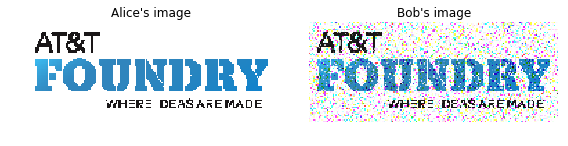

In [6]:
# Run the agents
start = time.time()
Simulation(alice, bob, charlie).run()

print("Transmitted {} bits in {:.3f}s.".format(len(out["Bob"]), time.time() - start))
t_alice, t_bob, t_charlie = out["Alice"]["t"], out["Bob"]["t"], out["Charlie"]["t"]
print("Simulated time: Alice: {:.2e}s, Bob: {:.2e}s, Charlie: {:.2e}s"
      .format(t_alice, t_bob, t_charlie))
received = np.reshape(np.packbits(out["Bob"]["bits"]), img.shape)
f, ax = plt.subplots(1, 2, figsize = (8, 4))
ax[0].imshow(img)
ax[0].axis('off')
ax[0].title.set_text("Alice's image")
ax[1].imshow(received)
ax[1].axis('off')
ax[1].title.set_text("Bob's image")
plt.tight_layout()
plt.show()